In [19]:
import json
import os
from distutils.dir_util import copy_tree
import shutil
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
print('TensorFlow version: ', tf.__version__)

TensorFlow version:  2.9.1


In [20]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to c:\users\junho\appdata\local\temp\pip-req-build-dv1pfle4
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models 'C:\Users\junho\AppData\Local\Temp\pip-req-build-dv1pfle4'
  Running command git submodule update --init --recursive -q


In [21]:
dataset_path = os.path.join(os.getcwd(), 'data')

tmp_debug_path = '.\\tmp_debug'
print('Creating Directory: ' + tmp_debug_path)
os.makedirs(tmp_debug_path, exist_ok=True)

def get_filename_only(file_path):
    file_basename = os.path.basename(file_path)
    filename_only = file_basename.split('.')[0]
    return filename_only

Creating Directory: .\tmp_debug


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from efficientnet.tfkeras import EfficientNetB0 #EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

input_size = 128
batch_size_num = 32
train_path = os.path.join(dataset_path, 'dataset')
val_path = os.path.join(dataset_path, 'dataset')
test_path = os.path.join(dataset_path, 'dataset')

train_datagen = ImageDataGenerator(
    rescale = 1/255,    #rescale the tensor values to [0,1]
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = "binary",  #"categorical", "binary", "sparse", "input"
    batch_size = batch_size_num,
    shuffle = True
    #save_to_dir = tmp_debug_path
)

val_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

val_generator = train_datagen.flow_from_directory(
    directory = val_path,
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = "binary",  #"categorical", "binary", "sparse", "input"
    batch_size = batch_size_num,
    shuffle = True,
    subset='validation'
    #save_to_dir = tmp_debug_path
)

test_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    classes=['real', 'fake'],
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = None,
    batch_size = 1,
    shuffle = False
)

# Train a CNN classifier
efficient_net = EfficientNetB0(
    weights = 'imagenet',
    input_shape = (input_size, input_size, 3),
    include_top = False,
    pooling = 'max'
)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [28]:
model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.summary()

# Compile model
model.compile(optimizer = Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '.\\tmp_checkpoint'
print('Creating Directory: ' + checkpoint_filepath)
os.makedirs(checkpoint_filepath, exist_ok=True)

custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 5,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'best_model.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

# Train network
num_epochs = 20
history = model.fit_generator(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    callbacks = custom_callbacks
)
print(history.history)

# load the saved model that is considered the best
best_model = load_model(os.path.join(checkpoint_filepath, 'best_model.h5'))

# Generate predictions
test_generator.reset()

preds = best_model.predict(
    test_generator,
    verbose = 1
)

test_results = pd.DataFrame({
    "Filename": test_generator.filenames,
    "Prediction": preds.flatten()
})
print(test_results)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1280)             4049564   
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,771,229
Trainable params: 4,729,213
Non-trainable params: 42,016
_______________________________________

C:\Users\junho\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\junho\AppData\Local\Temp\ipykernel_17116\3289612399.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 1.1346 - accuracy: 0.5280
Epoch 1: val_loss improved from inf to 0.68097, saving model to .\tmp_checkpoint\best_model.h5
63/63 [==============================] - 47s 563ms/step - loss: 1.1346 - accuracy: 0.5280 - val_loss: 0.6810 - val_accuracy: 0.5825
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.7941 - accuracy: 0.5940
Epoch 2: val_loss improved from 0.68097 to 0.62186, saving model to .\tmp_checkpoint\best_model.h5
63/63 [==============================] - 33s 522ms/step - loss: 0.7941 - accuracy: 0.5940 - val_loss: 0.6219 - val_accuracy: 0.6625
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.6405
Epoch 3: val_loss improved from 0.62186 to 0.57339, saving model to .\tmp_checkpoint\best_model.h5
63/63 [==============================] - 33s 527ms/step - loss: 0.6877 - accuracy: 0.6405 - val_loss: 0.5734 - val_accuracy: 0.6875
Epoch 4/20
63/63 [===========

In [ ]:
print(test_results)

                                Filename  Prediction
0     real\Celeb-real_id0_0001_00000.png    0.854930
1     real\Celeb-real_id0_0001_00030.png    0.860382
2     real\Celeb-real_id0_0001_00060.png    0.624944
3     real\Celeb-real_id0_0001_00090.png    0.660572
4     real\Celeb-real_id0_0001_00120.png    0.849854
...                                  ...         ...
1995         fake\id9_id6_0000_00060.png    0.074033
1996         fake\id9_id6_0000_00120.png    0.072817
1997         fake\id9_id6_0005_00000.png    0.058579
1998         fake\id9_id6_0005_00060.png    0.015735
1999         fake\id9_id6_0005_00120.png    0.339116

[2000 rows x 2 columns]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

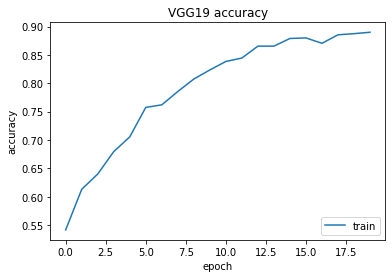

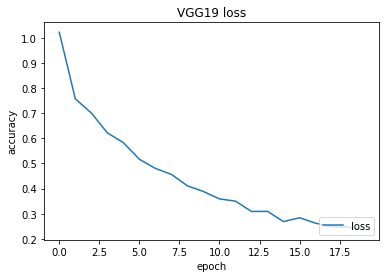

In [ ]:

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('VGG19 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
# plt.plot(history.history['val_accuracy'])
plt.title('VGG19 loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'test'], loc='lower right')
plt.show()

In [ ]:
df = pd.DataFrame()
for idx, key in enumerate(history.history.keys()):
    row = pd.DataFrame(data={
      'item': key,
      'max': max(history.history[key]),
      'mean': np.mean(history.history[key]),
      'min': min(history.history[key]),
    }, index=[idx])
    df = pd.concat([df,row])

from IPython.display import HTML
df.sort_values(by=['item'],ascending=True)
HTML(df.to_html(index=False))

item,max,mean,min
loss,1.022331,0.440577,0.235546
accuracy,0.890000,0.791100,0.541500
val_loss,0.696366,0.336269,0.179185
val_accuracy,0.918500,0.838300,0.582000


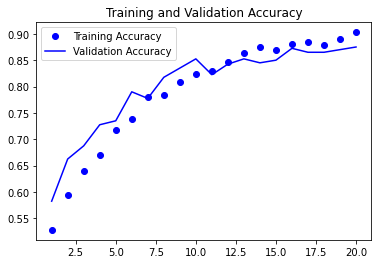

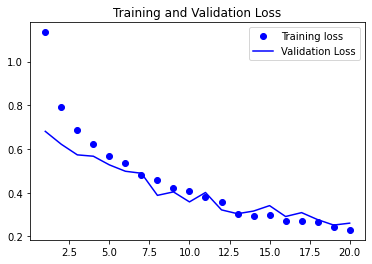

In [31]:
# # Plot results
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()